#### Лабораторная работа № 3 «Сегментация изображений с помощью глубоких нейронных сетей»

In [1]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/viacheslavshalamov/russian-road-signs-segmentation-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading russian-road-signs-segmentation-dataset.zip to ./russian-road-signs-segmentation-dataset


100%|██████████| 401M/401M [01:59<00:00, 3.53MB/s] 


In [2]:
from torchvision import models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

model = models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, 2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [3]:
from torchvision.ops import masks_to_boxes
import PIL.ImageDraw as ImageDraw,PIL.Image as Image


def get_mask_and_boxes(im_name, t, w , h):
    all_masks = list()
    H = t['file_attributes']['height']
    W = t['file_attributes']['width']

    scale_y = h / H
    scale_x = w / W

    for r in t["regions"].keys():
        im = Image.new("RGB", (w, h), "black")
        draw = ImageDraw.Draw(im)
        if t['regions'][r]['shape_attributes']['name'] == 'polygon':
            x = t['regions'][r]['shape_attributes']['all_points_x']
            y = t['regions'][r]['shape_attributes']['all_points_y']
            coord = list()
            for (x1, y1) in zip(x, y):
                coord.append((x1 * scale_x, y1 * scale_y))
            draw.polygon(coord, fill='#ffffff')
        elif t['regions'][r]['shape_attributes']['name'] == 'ellipse':
            u=t['regions'][r]['shape_attributes']['cx'] * scale_x
            v=t['regions'][r]['shape_attributes']['cy'] * scale_y
            a=t['regions'][r]['shape_attributes']['rx'] * scale_x
            b=t['regions'][r]['shape_attributes']['ry'] * scale_y
            shape = [u-a, v-b, u+a, v+b]
            draw.ellipse(shape, fill ="#ffffff")
        elif t['regions'][r]['shape_attributes']['name'] == 'rect':
            x=t['regions'][r]['shape_attributes']['x'] * scale_x
            y=t['regions'][r]['shape_attributes']['y'] * scale_y
            width=t['regions'][r]['shape_attributes']['width'] * scale_x
            height=t['regions'][r]['shape_attributes']['height'] * scale_y
            shape = [x, y, x + width, y + height]
            draw.rectangle(shape, fill ="#ffffff")
        elif t['regions'][r]['shape_attributes']['name'] == 'circle':
            u=t['regions'][r]['shape_attributes']['cx'] * scale_x
            v=t['regions'][r]['shape_attributes']['cy'] * scale_y
            a=t['regions'][r]['shape_attributes']['r'] * scale_x
            b=t['regions'][r]['shape_attributes']['r'] * scale_y
            shape = [u-a, v-b, u+a, v+b]
            draw.ellipse(shape, fill ="#ffffff")
        else:
            print("unkhown figure " + t['regions'][r]['shape_attributes']['name'])
            print(im_name)
        mask = np.array(im)
        new_mask = list()
        need_add_mask = False
        for i in range(h):
            n = list()
            for j in range(w):
                if mask[i][j][0] == 255:
                    need_add_mask = True
                    n.append(True)
                else:
                    n.append(False)
            new_mask.append(n)
        if need_add_mask:
            all_masks.append(new_mask)

    all_masks = torch.FloatTensor(np.array(all_masks))
    boxes = masks_to_boxes(all_masks)
    for box in boxes:
        box[2] += 1
        box[3] += 1
    return all_masks, boxes

In [4]:
import os
import json
import numpy as np
import torch
from PIL import Image
from torchvision import transforms


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list()
        for i in list(sorted(os.listdir(root))):
            if not ".json" in i:
                self.imgs.append(i)
        f = open(os.path.join(self.root, "via_region_data.json"))
        data = json.load(f)
        self.dict_mask = {}
        for t in data.values():
            self.dict_mask[t["filename"]] = t

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.imgs[idx])
        new_size = (300, 300)
        img = Image.open(img_path).convert("RGB").resize(new_size)
        masks, boxes = get_mask_and_boxes(self.imgs[idx], self.dict_mask[self.imgs[idx]], new_size[0], new_size[1])
        num_objs = masks.shape[0]
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)


data_transform = transforms.Compose([
        transforms.ToTensor()
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MyDataset(
    "russian-road-signs-segmentation-dataset/sign_dataset/train",
    data_transform
)

test_dataset = MyDataset(
    "russian-road-signs-segmentation-dataset/sign_dataset/val",
    data_transform
)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn)

In [ ]:
from tqdm import tqdm

num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for imgs, annotations in tqdm(data_loader):
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, loss : {epoch_loss}')

In [ ]:
torch.save(model.state_dict(),f'model_mask.pt')

In [5]:
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

model = models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, 2)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.load_state_dict(torch.load(f'model_mask.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

100%|██████████| 8/8 [02:17<00:00, 17.24s/it]


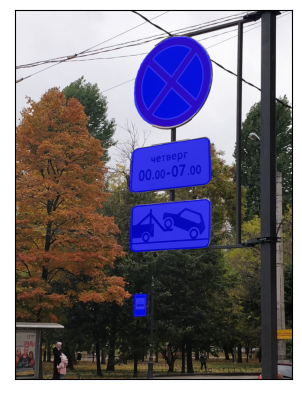

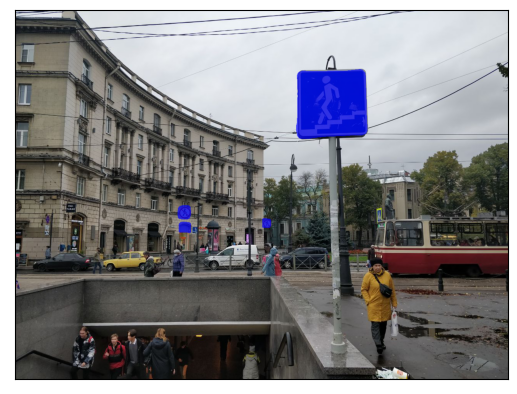

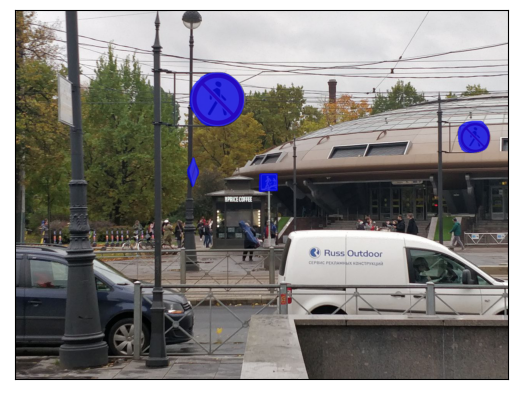

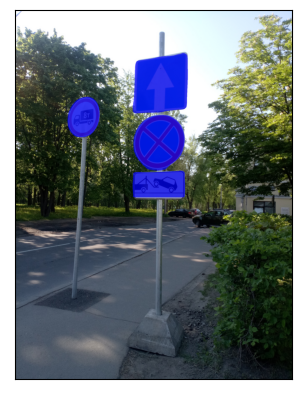

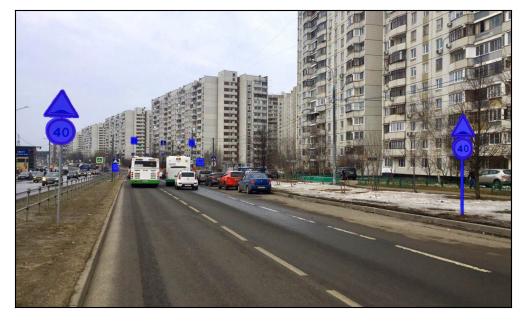

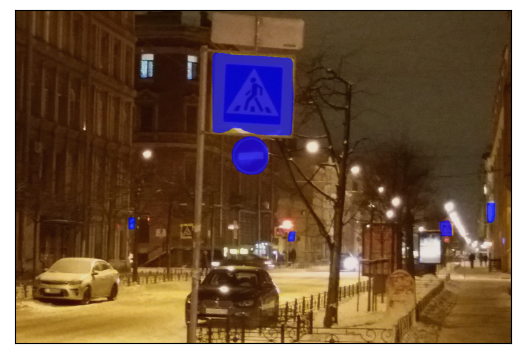

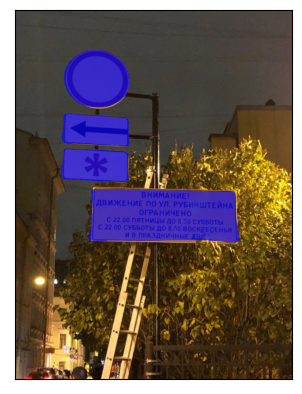

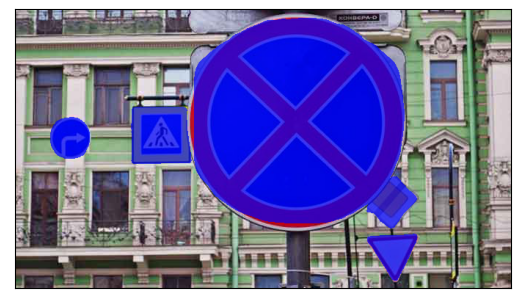

In [19]:
from torchvision.utils import draw_segmentation_masks
from torchvision.io import read_image
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from tqdm import tqdm


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def make_prediction(model, path, threshold):
    img = Image.open(path).convert("RGB")
    convert_tensor = transforms.Compose([
        transforms.ToTensor()
    ])
    img = convert_tensor(img).clone().to(device)
    model.eval()
    l = list()
    l.append(img)
    preds = model(l)
    for id in range(len(preds)):
        idx_list = []
        for idx, score in enumerate(preds[id]['scores']):
            if score > threshold:
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['masks'] = preds[id]['masks'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds


with torch.no_grad():
    for i in tqdm(range(8)):
        file_path = "test_mask/" + str(i + 1) + ".jpg"
        img = read_image(file_path)
        m = np.zeros((img.shape[1], img.shape[2]))
        drawn_masks = []
        pred = make_prediction(model, file_path, 0.5)
        for mask in pred[0]['masks']:
            mask = mask[0].cpu().numpy()
            for i in range(len(mask)):
                for j in range(len(mask[0])):
                    m[i][j] = m[i][j] or (mask[i][j] > 0.5)
        drawn_masks.append(draw_segmentation_masks(img, torch.BoolTensor(m), alpha=0.7, colors="blue"))
        show(drawn_masks)

In [7]:
from tqdm import tqdm


def make_prediction_with_img(model, img):
    model.eval()
    preds = model(img)
    return preds


predictions = list()
targets = list()
for imgs, target in tqdm(test_data_loader):
    imgs = list(img.to(device) for img in imgs)
    with torch.no_grad():
        pred = make_prediction_with_img(model, imgs)
        if len(pred[0]['masks']) == 0:
            continue
        shape = pred[0]['masks'][0].shape
        m = np.zeros((shape[1], shape[2]))
        pred = make_prediction_with_img(model, imgs)
        for mask in pred[0]['masks']:
            mask = mask[0].numpy()
            for i in range(len(mask)):
                for j in range(len(mask[0])):
                    m[i][j] = m[i][j] or (mask[i][j] > 0.5)
        predictions.append(m)
        targets.append(target)

100%|██████████| 127/127 [26:21<00:00, 12.45s/it]


In [10]:
import math
import statistics


def count_one(m):
    count = 0
    for i in range(len(m)):
        for j in range(len(m[0])):
            if m[i][j] == 1:
                count += 1
    return count


def or_arrays(n, m):
    ans = list()
    for i in range(len(m)):
        k = list()
        for j in range(len(m[0])):
            if m[i][j] == 1 or n[i][j] == 1:
                k.append(1)
            else:
                k.append(0)
        ans.append(k)
    return ans


def and_arrays(n, m):
    ans = list()
    for i in range(len(m)):
        k = list()
        for j in range(len(m[0])):
            if m[i][j] == 1 and n[i][j] == 1:
                k.append(1)
            else:
                k.append(0)
        ans.append(k)
    return ans


def div_arrays(n, m):
    f = count_one(and_arrays(n, m))
    g = count_one(m)
    return f / g


def culc_iou(n, m):
    ands = and_arrays(n, m)
    ors = or_arrays(n, m)
    return div_arrays(ands, ors)


def culc_recall(n, m):
    ands = and_arrays(n, m)
    return div_arrays(ands, m)


def culc_precision(n, m):
    ands = and_arrays(n, m)
    return div_arrays(ands, n)


def culc_l2(n, m):
    count = 0
    for i in range(len(m)):
        for j in range(len(m[0])):
            if m[i][j] != n[i][j]:
                count += 1
    return math.sqrt(count) / count


L2s = list()
IoUs = list()
recalls = list()
precisions = list()

for i in tqdm(range(len(predictions))):
    pred = predictions[i]
    shape = predictions[i].shape
    m = np.zeros((shape[0], shape[1]))
    for mask in targets[i][0]["masks"]:
        for k in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                m[k][j] = m[k][j] or mask[k][j]
    IoUs.append(culc_iou(pred, m))
    recalls.append(culc_recall(pred, m))
    precisions.append(culc_precision(pred, m))
    L2s.append(culc_l2(pred, m))

print("IoU : " + str(statistics.mean(IoUs)))
print("Recall : " + str(statistics.mean(recalls)))
print("Precision : " + str(statistics.mean(precisions)))
print("L2 : " + str((statistics.mean(L2s))))

l = len(IoUs)
l50 = len(list(filter(lambda score: score >= 0.5, IoUs)))
l75 = len(list(filter(lambda score: score >= 0.75, IoUs)))
l90 = len(list(filter(lambda score: score >= 0.9, IoUs)))
print("IoU >= 0.5 : " + str(l50 / l * 100))
print("IoU >= 0.75 : " + str(l75 / l * 100))
print("IoU >= 0.9 : " + str(l90 / l * 100))

100%|██████████| 126/126 [02:41<00:00,  1.28s/it]

IoU : 0.7328856153604317
Recall : 0.7981530886359309
Precision : 0.6353627277863693
L2 : 0.0039915341489621635
IoU >= 0.5 : 96.66666666666666
IoU >= 0.75 : 40.63492063492063
IoU >= 0.9 : 11.587301587301587
